# Previsão da probabilidade de abstenção do candidato
- Neste notebook, será realizada uma tarefa de classificação, que consiste na previsão da probabilidade de abstenção do candidato no enem (target binário, presente/ausente, 0/1, dados desbalanceados) com base nas variáveis que vimos na análise exploratória de dados. Será aplicado o aprendizado supervisionado, com um conjunto de dados rotulado e um target binário.
- O objetivo consiste em construir um modelo de machine learning capaz de prever, com confiança, a probabilidade de abstenção do candidato. Além disso, avaliar quais variáveis independentes impactam mais e menos a abstenção.
- Para isso, técnicas de limpeza e pré-processamento de dados, treinamento e validação de modelos de machine learning serão aplicadas.
- Todo esse processo será baseado no framework CRISP-DM, podendo envolver ciclos de pré-processamento e validação de modelos repetidamente.
- Pipeline de modelagem:
    - Divisão dos dados em treino, teste e validação.
    - Feature engineering e pré-processamento dos dados
    - Feature selection
    - Comparação e seleção de modelo potencial com validação cruzada k-fold estratificada.
    - Tunagem de hiperparâmetros.
    - Calibração de probabilidades
    - Avaliação final no conjunto de testes (simulando o ambiente de produção).
    - Deploy.
- Finalmente, um modelo de previsão de probabilidade de abstenção pode ser uma ferramenta valiosa para melhorar a eficácia das políticas educacionais e facilitar o processo de organização de exames. Alguns exemplos de aplicações:
    - Identificação de Riscos de Abstenção.
    - Intervenções Preventivas.
    - Aprimoramento da Comunicação.
    - Otimização de Recursos.
    - Planejamento Estratégico.
    - Avaliação do Impacto de Medidas Anteriores.
    - Melhoria da Qualidade do Exame.
- É importante destacar que aqui a intenção é obter uma probabilidade de abstenção confiável, além de ordenar a base de candidatos. Portanto, será realizada a calibração de probabilidades e não utilizarei técnicas que podem ir na contramão dessa calibração (mas que aumentam o desempenho), como class weights.

#### 1. Importando as bibliotecas

In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import optuna
import shap
shap.initjs()

# Definições de cores -> todas estão numa escala de mais escura para mais clara.
VERMELHO_FORTE = '#461220'
CINZA1, CINZA2, CINZA3 = '#231F20', '#414040', '#555655'
CINZA4, CINZA5, CINZA6 = '#646369', '#76787B', '#828282'
CINZA7, CINZA8, CINZA9 = '#929497', '#A6A6A5', '#BFBEBE'
AZUL1, AZUL2, AZUL3, AZUL4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
VERMELHO1, VERMELHO2, VERMELHO3, VERMELHO4, VERMELHO5 = '#DB0527', '#E23652', '#ED8293', '#F4B4BE', '#FBE6E9'
VERDE1, VERDE2 = '#0C8040', '#9ABB59'
LARANJA1 = '#F79747'
AMARELO1, AMARELO2, AMARELO3, AMARELO4, AMARELO5 = '#FFC700', '#FFCC19', '#FFEB51', '#FFE37F', '#FFEEB2'
BRANCO = '#FFFFFF'

# Visualize all the columns.
pd.set_option('display.max_columns', None)

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
%cd ../
from src.modelling_utils import *
from src.eda_utils import bar_plot

/Users/pedrohenriquealmeidaoliveira/Documents/UnB/tcc/enem-2023/enem-2023/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/pedrohenriquealmeidaoliveira/Documents/UnB/tcc/enem-2023/enem-2023


#### 2. Coletando os dados
- Considerando que estamos tentando prever a probabilidade de abstenção do candidato, serão incluídos na modelagem todos os dados, como visto na Análise de Abstenção no notebook '2_eda.ipynb'. Dessa forma, incluiremos não só os estudantes que compareceram, mas também aqueles que faltaram ao exame, os quais serão o alvo da modelagem.
- Antes de tudo, iremos criar o target para a modelagem de abstenção, que consiste em uma variável binária, indicando se o aluno estava ausente em pelo menos um dos dias de prova (1) ou presente (0, em ambos os dias de prova). Isso permitirá a divisão dos dados em treino, teste e validação e a aplicação correta do pré-processamento dos dados.

In [2]:
# Read the memory optimized data.
path = 'input/data/clean_df.parquet'
df = pd.read_parquet(path)

# Create our target, a feature indicating wheter the student was absent in at least one day of the exam (1).
df['abstencao'] = (df['presenca_lc'] == 'Ausente') | \
                  (df['presenca_ch'] == 'Ausente') | \
                  (df['presenca_cn'] == 'Ausente') | \
                  (df['presenca_mt'] == 'Ausente') 
df['abstencao'] = df['abstencao'].astype('int8')

- Estamos lidando com uma tarefa de classificação desbalanceada. O nosso target contempla 32% de observações positivas para abstenção (evento de interesse).
- Portanto, algumas estratégias de modelagem serão adotadas:
    - Feature engineering na criação de features que ajudem o modelo a discriminar entre o evento (abstenção, 1) e o não evento.
    - Divisão ESTRATIFICADA dos dados em treino, teste e validação.
    - Validação cruzada k-fold ESTRATIFICADA para acessar a capacidade de generalização do modelo e realizar testes de forma confiável.
    - Escolha de métricas orientadas a uma avaliação de performance condizente com o desbalanceamento, como ROC-AUC, Brier, etc.
- Apesar de os nossos dados estarem desbalanceados, esse desbalanceamento não é alarmante. Considerando que há mais de 3 milhões de observações, é provável que não tenhamos problemas com essa característica e o modelo seja capaz de aprender bem os padrões por trás da classe rara. Entretanto, para fins de metodologia, garantia de performance e conhecimento, serão seguidas as técnicas supracitadas.

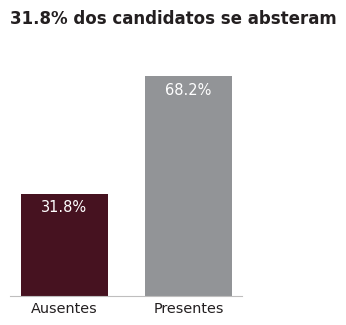

In [3]:
# Group the data by the target.
abstencao_grouped = df.groupby(['abstencao'])[['abstencao']].count().rename(columns={'abstencao': 'count'}).reset_index().sort_values(by=['count'], ascending=False)
abstencao_grouped['pct'] = round(abstencao_grouped['count'] / np.sum(abstencao_grouped['count']) * 100, 2) 
abstencao_grouped = abstencao_grouped.sort_values(by=['pct'], ascending=True)
abstencao_grouped['abstencao'].iloc[0] = 'Ausentes'
abstencao_grouped['abstencao'].iloc[1] = 'Presentes'

bar_plot(abstencao_grouped, 'abstencao', 'pct', title='31.8% dos candidatos se absteram',
         xlabel='', figsize=(3, 3), barwidth=0.7, bar_color=[VERMELHO_FORTE, CINZA7], )

#### 2.1 Rápida visualização e informações gerais

In [4]:
df.head()

,faixa_etaria,sexo,estado_civil,status_conclusao_ensino_medio,ano_concluiu,escola,treineiro,uf_prova,presenca_cn,presenca_ch,presenca_lc,presenca_mt,nota_cn,nota_ch,nota_lc,nota_mt,lingua,nota_redacao,escolaridade_pai,escolaridade_mae,ocupacao_pai,ocupacao_mae,numero_pessoas_em_casa,renda_familiar_mensal,dias_empregado_domestico_em_casa,numero_banheiros_em_casa,numero_quartos_em_casa,numero_carros_em_casa,numero_motos_em_casa,numero_geladeiras_em_casa,numero_freezers_em_casa,numero_lavadoras_em_casa,numero_secadoras_em_casa,numero_microondas_em_casa,numero_lavadoras_de_loucas_em_casa,possui_aspirador_de_po_em_casa,numero_tvs_em_casa,possui_dvd_em_casa,possui_tv_assinatura_em_casa,numero_celulares_em_casa,possui_telefone_fixo_em_casa,numero_computadores_em_casa,possui_acesso_a_internet_em_casa,abstencao
0,Adulto de meia idade (36-45),M,Casado(a)/União Estável,Concluído,17,Não respondeu,Não,DF,Ausente,Ausente,Ausente,Ausente,0.0,0.000000,0.000000,0.000000,Inglês,0.0,Nunca estudou,Ensino superior completo,Profissionais e Liderança,Técnicos e Pequenos Negócios,5,"R$ 3.300,01 - R$ 3.960,00",Dois,Dois,Três,Dois,Três,Dois,Um,Um,Três,Dois,Dois,Sim,Um,Não,Sim,Um,Não,Zero,Sim,1
1,Adulto jovem (25-35),M,Casado(a)/União Estável,Concluído,16,Não respondeu,Não,DF,Ausente,Ausente,Ausente,Ausente,0.0,0.000000,0.000000,0.000000,Inglês,0.0,Ensino superior completo,Ensino médio completo,Profissionais e Liderança,Serviços Gerais,3,"R$ 5.280,01 - R$ 6.600,00",Zero,Um,Dois,Dois,Zero,Um,Um,Um,Zero,Um,Zero,Sim,Um,Não,Não,Dois,Não,Três,Sim,1
2,Jovem adulto (20-24),F,Solteiro(a),Concluído,0,Não respondeu,Não,RS,Presente,Presente,Presente,Presente,502.0,498.899994,475.600006,363.200012,Espanhol,700.0,Não sei,Ensino médio completo,Produção e Operações,Não Informado,5,"R$ 1.320,01 - R$ 1.980,00",Zero,Um,Três,Um,Zero,Um,Zero,Um,Zero,Um,Zero,Não,Um,Não,Não,Zero,Não,Zero,Sim,0
3,Adolescente (< 18),F,Solteiro(a),Último ano,0,Pública,Não,CE,Presente,Presente,Presente,Presente,459.0,508.500000,507.200012,466.700012,Inglês,880.0,Ensino fundamental completo,Ensino fundamental completo,Serviços Gerais,Serviços Gerais,5,"R$ 1.320,01 - R$ 1.980,00",Zero,Um,Um,Zero,Zero,Um,Zero,Zero,Zero,Zero,Zero,Não,Um,Não,Não,Três,Não,Zero,Sim,0
4,Jovem (18-20),F,Solteiro(a),Último ano,0,Pública,Não,CE,Presente,Presente,Presente,Presente,402.5,379.200012,446.899994,338.299988,Inglês,560.0,Ensino fundamental incompleto,Ensino fundamental incompleto,Agropecuária,Agropecuária,4,"Até R$ 1.320,00",Zero,Um,Zero,Zero,Zero,Um,Zero,Zero,Zero,Zero,Zero,Não,Um,Não,Não,Um,Não,Zero,Não,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927146 entries, 0 to 3927145
Data columns (total 44 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   faixa_etaria                        category
 1   sexo                                category
 2   estado_civil                        category
 3   status_conclusao_ensino_medio       category
 4   ano_concluiu                        int64   
 5   escola                              category
 6   treineiro                           category
 7   uf_prova                            category
 8   presenca_cn                         category
 9   presenca_ch                         category
 10  presenca_lc                         category
 11  presenca_mt                         category
 12  nota_cn                             float32 
 13  nota_ch                             float32 
 14  nota_lc                             float32 
 15  nota_mt                         

In [7]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 3927146 linhas e 44 colunas.


#### 2.2 Valores nulos e duplicados
- Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook '1_data_cleaning.ipynb'. Além disso, muitas variáveis irrelevantes já foram removidas. Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

In [8]:
df.isna().sum()

faixa_etaria                          0
sexo                                  0
estado_civil                          0
status_conclusao_ensino_medio         0
ano_concluiu                          0
escola                                0
treineiro                             0
uf_prova                              0
presenca_cn                           0
presenca_ch                           0
presenca_lc                           0
presenca_mt                           0
nota_cn                               0
nota_ch                               0
nota_lc                               0
nota_mt                               0
lingua                                0
nota_redacao                          0
escolaridade_pai                      0
escolaridade_mae                      0
ocupacao_pai                          0
ocupacao_mae                          0
numero_pessoas_em_casa                0
renda_familiar_mensal                 0
dias_empregado_domestico_em_casa      0


#### 2.3 Variáveis numéricas e categóricas
- Irei verificar as variáveis numéricas e categóricas.
- Isso influenciará a escolha de encoders e scalers futuramente na etapa de pré-processamento de dados. Cardinalidade é um fator importante a ser considerado.

In [3]:
categorical_features = df.select_dtypes(['category', 'object']).columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(f'Há {len(numerical_features)} variáveis numéricas. São elas: {numerical_features}')

Há 36 variáveis categóricas. São elas: ['faixa_etaria', 'sexo', 'estado_civil', 'status_conclusao_ensino_medio', 'escola', 'treineiro', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'lingua', 'escolaridade_pai', 'escolaridade_mae', 'ocupacao_pai', 'ocupacao_mae', 'renda_familiar_mensal', 'dias_empregado_domestico_em_casa', 'numero_banheiros_em_casa', 'numero_quartos_em_casa', 'numero_carros_em_casa', 'numero_motos_em_casa', 'numero_geladeiras_em_casa', 'numero_freezers_em_casa', 'numero_lavadoras_em_casa', 'numero_secadoras_em_casa', 'numero_microondas_em_casa', 'numero_lavadoras_de_loucas_em_casa', 'possui_aspirador_de_po_em_casa', 'numero_tvs_em_casa', 'possui_dvd_em_casa', 'possui_tv_assinatura_em_casa', 'numero_celulares_em_casa', 'possui_telefone_fixo_em_casa', 'numero_computadores_em_casa', 'possui_acesso_a_internet_em_casa']
Há 8 variáveis numéricas. São elas: ['ano_concluiu', 'nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_redacao', 'numero_pessoas_e

In [7]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
faixa_etaria (7), sexo (2), estado_civil (5), status_conclusao_ensino_medio (4), escola (3), treineiro (2), uf_prova (27), presenca_cn (2), presenca_ch (2), presenca_lc (2), presenca_mt (2), lingua (2), escolaridade_pai (7), escolaridade_mae (7), ocupacao_pai (6), ocupacao_mae (6), renda_familiar_mensal (17), dias_empregado_domestico_em_casa (4), numero_banheiros_em_casa (5), numero_quartos_em_casa (5), numero_carros_em_casa (5), numero_motos_em_casa (5), numero_geladeiras_em_casa (5), numero_freezers_em_casa (5), numero_lavadoras_em_casa (5), numero_secadoras_em_casa (5), numero_microondas_em_casa (5), numero_lavadoras_de_loucas_em_casa (5), possui_aspirador_de_po_em_casa (2), numero_tvs_em_casa (5), possui_dvd_em_casa (2), possui_tv_assinatura_em_casa (2), numero_celulares_em_casa (5), possui_telefone_fixo_em_casa (2), numero_computadores_em_casa (5), possui_acesso_a_internet_em_casa (2), 

In [8]:
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({df[feature].value_counts(normalize=True) * 100})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (faixa_etaria
Jovem (18-20)                         40.772205
Adolescente (< 18)                    27.997049
Jovem adulto (20-24)                  13.331310
Adulto jovem (25-35)                  11.509631
Adulto de meia idade (36-45)           4.169618
Meia idade a aposentadoria (46-65)     2.143287
Idoso (> 66)                           0.076901
Name: proportion, dtype: float64)

sexo (sexo
F    61.314069
M    38.685931
Name: proportion, dtype: float64)

estado_civil (estado_civil
Solteiro(a)                  88.764818
Casado(a)/União Estável       5.094743
Não informado                 4.368720
Divorciado(a)/Separado(a)     1.649799
Viúvo(a)                      0.121921
Name: proportion, dtype: float64)

status_conclusao_ensino_medio (status_conclusao_ensino_medio
Concluído        48.178015
Último ano       35.615202
Cursando         15.763992
Não concluído     0.442790
Name: proportion, dtype: float64)

escola (escola
Não responde

#### 3. Train-val-test split
- Os dados de teste devem ser dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
- Os dados de validação serão utilizados na calibração de probabilidades.
- Os dados de treino serão utilizados para qualquer atividade no desenvolvimento do modelo, como feature selection, validação cruzada e tunagem de hiperparâmetros.
- Irei especificar o parâmetro stratify=y. Isso fará com que a proporção das classes positiva e negativa do target sejam mantidas em todos os conjuntos, evitando que o desbalanceamento afete as nossas amostras e a nossa avaliação de performance futura. Queremos o fenômeno bem representado em cada uma das amostras.

In [3]:
# Obtain predictor and target sets.
X = df.drop(columns=['abstencao'])
y = df['abstencao'].copy()

# Set 80% training, 7.5% test and 7.5% validation. There are a lot of data. Thus, it is not necessary to use a high proportion for test and validation sets.
# Set stratify=y in order to maintain target classes proportions.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (3338074, 43). Train target set shape: (3338074,)
Test predictor set shape: (294536, 43). Test target set shape: (294536,)
Validation predictor set shape: (294536, 43). Validation target set shape: (294536,)


In [5]:
print(f'Train set target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest set target classes proportions:')
print(y_test.value_counts(normalize=True))
print(f'\nValidation set target classes proportions:')
print(y_val.value_counts(normalize=True))

Train set target classes proportions: 
abstencao
0    0.681987
1    0.318013
Name: proportion, dtype: float64

Test set target classes proportions:
abstencao
0    0.681988
1    0.318012
Name: proportion, dtype: float64

Validation set target classes proportions:
abstencao
0    0.681988
1    0.318012
Name: proportion, dtype: float64


- Perfeito! A divisão dos dados em treino, teste e validação foi feita corretamente e a proporção das classes do target foi mantida em cada um desses conjuntos.

#### 3. Feature engineering e pré-processamento dos dados
- Combinarei categorias de variáveis a fim de reduzir o número de categorias final e evitar problemas como categorias com baixíssima proporção (podem levar a overfit). Portanto, serão combinadas categorias adjacentes com semelhante discriminatividade entre presentes e ausentes, e com proporções baixíssimas. É o caso de variáveis como renda, número de pessoas em casa, e algumas de contagem do questionário socioeconômico. A variável de estado poderá ser transformada em região, dada sua alta cardinalidade. A variável município prova, por não ter combinação tão natural e altíssima cardinalidade, será removida.
- Variáveis de comportamento ordinal serão aplicadas ao ordinal encoding a fim de manter esse padrão (que pode ser informativo ao modelo). Variáveis binárias serão aplicadas ao one hot encoding. Aplicarei target encoding às demais, uma vez que one hot encoding aumentaria demais o número de categorias e tornaria a feature selection muito custosa computacionalmente e elas não possuem aspecto ordinal. Além disso, algoritmos baseados em árvore (utilizados na feature selection) podem ser prejudicados pelo uso de one hot encoding.
- Criarei features como flags, scores (a partir das perguntas do questionário socioeconômico e variáveis desse cunho) de tecnologia, conforto, suporte dos pais, etc. Variáveis razão a partir da renda e número de pessoas em casa, entre outras abaixo.
- *Nas variáveis representando a escolaridade do pai e da mãe, há uma categoria "Não sei". Esse valor se deve provavelmente por falta de conhecimento sobre a escolaridade do responsável por parte do candidato. Uma vez que essas observações constituem uma porção significativa dos dados (em escolaridade_pai, mais de 8%, por exemplo) e que a taxa de abstenção dentro dessa categoria é alta, estando próxima à de candidatos cuijos pais nunca estudaram, irei tratá-la como sendo mais uma categoria da variável. Imputar valores poderia ocasionar perda de informação relevante para o modelo, dada a alta frequência desses registros e a informação contida neles (segunda maior taxa de abstenção).
- *Apesar de a variável escola possuir 60% das observações registradas como "Não respondeu", irei incluí-la na modelagem. Isso porque foi visto na eda que as categorias pública e privada possuem clara distinção na abstenção. A taxa de abstenção é muito maior entre alunos de escola pública. Portanto, ela pode ajudar o modelo. Uma vez que as observações nulas mencionadas possuem a maior taxa de abstenção dentre as categorias e dado o seu altíssimo percentual, elas serão tratadas como mais uma categoria dessa variável.
- A fim de evitar data_leakage, variáveis representando a presença nas diferentes áreas do conhecimento serão removidas, afinal, não sabemos se um aluno está presente ou não no momento da predição, isso é justamente o que queremos prever. Incluí-las criaria um cenário irreal, superestimando a performance do modelo. O mesmo vale para features contendo a nota do candidato nas diferentes áreas do conhecimento, redação ou competências da redação. Da mesma forma, não sabemos qual a nota do candidato em nada no ambiente de produção.

In [4]:
feature_df = pd.concat([X_train, y_train], axis=1)

In [5]:
# Create region variable.
region_mapping = {
            'AC': 'Norte',
            'AL': 'Nordeste',
            'AP': 'Norte',
            'AM': 'Norte',
            'BA': 'Nordeste',
            'CE': 'Nordeste',
            'DF': 'Centro-Oeste',
            'ES': 'Sudeste',
            'GO': 'Centro-Oeste',
            'MA': 'Nordeste',
            'MT': 'Centro-Oeste',
            'MS': 'Centro-Oeste',
            'MG': 'Sudeste',
            'PA': 'Norte',
            'PB': 'Nordeste',
            'PR': 'Sul',
            'PE': 'Nordeste',
            'PI': 'Nordeste',
            'RJ': 'Sudeste',
            'RN': 'Nordeste',
            'RS': 'Sul',
            'RO': 'Norte',
            'RR': 'Norte',
            'SC': 'Sul',
            'SP': 'Sudeste',
            'SE': 'Nordeste',
            'TO': 'Norte'
        }
feature_df['regiao'] = feature_df['uf_prova'].replace(region_mapping)

# Discretize number of people at home.
feature_df['numero_pessoas_em_casa_cat'] = pd.cut(feature_df['numero_pessoas_em_casa'], bins=[0, 3, 5, float('inf')],labels=['Até 3 pessoas', '4 a 5 pessoas', '6 ou mais pessoas'], include_lowest=True)

# Combine similar target distributed low proportion income categories.
income_mapping = {
                            'Nenhuma Renda': 'Nenhuma Renda',
                            'Até R$ 1.320,00': 'Renda Baixa',
                            'R$ 1.320,01 - R$ 1.980,00': 'Renda Baixa',
                            'R$ 1.980,01 - R$ 2.640,00': 'Renda Baixa',
                            'R$ 2.640,01 - R$ 3.300,00': 'Renda Média Baixa',
                            'R$ 3.300,01 - R$ 3.960,00': 'Renda Média Baixa',
                            'R$ 3.960,01 - R$ 5.280,00': 'Renda Média Baixa',
                            'R$ 5.280,01 - R$ 6.600,00': 'Renda Média Alta',
                            'R$ 6.600,01 - R$ 7.920,00': 'Renda Média Alta',
                            'R$ 7.920,01 - R$ 9.240,00': 'Renda Média Alta',
                            'R$ 9.240,01 - R$ 10.560,00': 'Renda Média Alta',
                            'R$ 10.560,01 - R$ 11.880,00': 'Renda Alta',
                            'R$ 11.880,01 - R$ 13.200,00': 'Renda Alta',
                            'R$ 13.200,01 - R$ 15.840,00': 'Renda Alta',
                            'R$ 15.840,01 - R$ 19.800,00': 'Renda Alta',
                            'R$ 19.800,01 - R$ 26.400,00': 'Renda Alta',
                            'Acima de R$ 26.400,00': 'Renda Alta'
                        }
feature_df['renda_familiar_mensal_cat'] = feature_df['renda_familiar_mensal'].replace(income_mapping)

# Combine similar target distributed low proportion age categories.
age_mapping = {
                        'Jovem (18-20)': 'Jovem (18-20)',
                        'Adolescente (< 18)': 'Adolescente (< 18)',
                        'Jovem adulto (20-24)': 'Jovem adulto (20-24)',
                        'Adulto jovem (25-35)': 'Adulto (25-45)',
                        'Adulto de meia idade (36-45)': 'Adulto (25-45)',
                        'Meia idade a aposentadoria (46-65)': 'Meia idade a idoso (46+)',
                        'Idoso (> 66)': 'Meia idade a idoso (46+)',
                    }
feature_df['faixa_etaria'] = feature_df['faixa_etaria'].replace(age_mapping)

# Combine similar target distributed low proportion estado civil categories.
estado_civil_mapping = {
            'Solteiro(a)': 'Solteiro(a)',
            'Casado(a)/União Estável': 'Casado(a)/União Estável',
            'Não informado': 'Não informado',
            'Divorciado(a)/Separado(a)': 'Divorciado/Viúvo',
            'Viúvo(a)': 'Divorciado/Viúvo'
        }
feature_df['estado_civil'] = feature_df['estado_civil'].replace(estado_civil_mapping)

# Common category mappings
map_two_or_more = {
            'Zero': 'Zero',
            'Um': 'Um',
            'Dois': 'Dois ou mais',
            'Três': 'Dois ou mais',
            'Quatro ou mais': 'Dois ou mais'
        }
map_one_or_more = {
            'Zero': 'Zero',
            'Um': 'Um ou mais',
            'Dois': 'Um ou mais',
            'Três': 'Um ou mais',
            'Quatro ou mais': 'Um ou mais'
        }

# Variables to apply each mapping
two_or_more_vars = [
            'numero_freezers_em_casa',
            'numero_geladeiras_em_casa',
            'numero_motos_em_casa',
            'numero_carros_em_casa',
            'numero_lavadoras_em_casa'
        ]
one_or_more_vars = [
            'numero_secadoras_em_casa',
            'numero_microondas_em_casa',
            'numero_lavadoras_de_loucas_em_casa'
        ]

# Apply mappings
for var in two_or_more_vars:
    feature_df[var] = feature_df[var].map(map_two_or_more)

for var in one_or_more_vars:
    feature_df[var] = feature_df[var].map(map_one_or_more)

# Combine ano_concluiu categories.
feature_df['ano_concluiu'] = feature_df['ano_concluiu'].apply(lambda x: 11 if x > 10 else x )

In [6]:
# Ordinal and one hot encode some variables for post feature engineering
escolaridade_orders = ['Nunca estudou', 'Não sei', 'Ensino fundamental incompleto', 'Ensino fundamental completo', 'Ensino médio completo', 'Ensino superior completo', 'Pós-graduação']
four_or_more_orders = ['Zero', 'Um', 'Dois', 'Três', 'Quatro ou mais']
two_or_more_orders = ['Zero', 'Um', 'Dois ou mais']
one_or_more_orders = ['Zero', 'Um ou mais']
ocupacao_orders = ['Não Informado', 'Agropecuária', 'Serviços Gerais', 'Produção e Operações', 'Técnicos e Pequenos Negócios', 'Profissionais e Liderança']
binary_orders = ['Não', 'Sim']
ordinal_encoding_orders = {
                            'faixa_etaria': ['Adolescente (< 18)', 'Jovem (18-20)', 'Jovem adulto (20-24)', 'Adulto (25-45)', 'Meia idade a idoso (46+)'],
                            'status_conclusao_ensino_medio': ['Não concluído', 'Cursando', 'Último ano', 'Concluído'],
                            'escolaridade_pai': escolaridade_orders,
                            'escolaridade_mae': escolaridade_orders,
                            'numero_pessoas_em_casa_cat': ['Até 3 pessoas', '4 a 5 pessoas', '6 ou mais pessoas'],
                            'renda_familiar_mensal_cat': ['Nenhuma Renda', 'Renda Baixa', 'Renda Média Baixa', 'Renda Média Alta', 'Renda Alta'],
                            'numero_quartos_em_casa': four_or_more_orders,
                            'numero_banheiros_em_casa': four_or_more_orders,
                            'numero_tvs_em_casa': four_or_more_orders,
                            'numero_celulares_em_casa': four_or_more_orders,
                            'numero_computadores_em_casa': four_or_more_orders,
                            'numero_geladeiras_em_casa': two_or_more_orders,
                            'dias_empregado_domestico_em_casa': ['Zero', 'Um', 'Dois', 'Três'],
                            'numero_freezers_em_casa': two_or_more_orders,
                            'numero_motos_em_casa': two_or_more_orders,
                            'numero_carros_em_casa': two_or_more_orders,
                            'numero_lavadoras_em_casa': two_or_more_orders,
                            'numero_secadoras_em_casa': one_or_more_orders,
                            'numero_microondas_em_casa': one_or_more_orders,
                            'numero_lavadoras_de_loucas_em_casa': one_or_more_orders,
                            'ocupacao_pai': ocupacao_orders,
                            'ocupacao_mae': ocupacao_orders,
                            'sexo': ['M', 'F'],
                            'lingua': ['Inglês', 'Espanhol'],
                            'treineiro': binary_orders, # binary, but equivalent to one hot encoding due to the presence of just two categories.
                            'possui_aspirador_de_po_em_casa': binary_orders,
                            'possui_dvd_em_casa': binary_orders,
                            'possui_tv_assinatura_em_casa': binary_orders,
                            'possui_telefone_fixo_em_casa': binary_orders,
                            'possui_acesso_a_internet_em_casa': binary_orders,
}
ordinal_encoder = OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)
feature_df = ordinal_encoder.fit_transform(feature_df)

In [7]:
# Feature engineering

# Flags (after encoding categorical variables)
feature_df['tem_carro'] = feature_df['numero_carros_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_moto'] = feature_df['numero_motos_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_geladeira'] = feature_df['numero_geladeiras_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_freezer'] = feature_df['numero_freezers_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_lavadora'] = feature_df['numero_lavadoras_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_tv'] = feature_df['numero_tvs_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_celular'] = feature_df['numero_celulares_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['tem_computador'] = feature_df['numero_computadores_em_casa'].apply(lambda x: 1 if x > 0 else 0)
feature_df['concluiu_ensino_medio'] = feature_df['status_conclusao_ensino_medio'].apply(lambda x: 1 if x == 'Concluído' else 0)
feature_df['tem_carro_ou_moto'] = feature_df['tem_carro'] | feature_df['tem_moto']
feature_df['tem_computador_ou_celular'] = feature_df['tem_computador'] | feature_df['tem_celular']
feature_df['tem_multiplas_tvs'] = feature_df['numero_tvs_em_casa'].apply(lambda x: 1 if x > 1 else 0)
feature_df['tem_multiplos_celulares'] = feature_df['numero_celulares_em_casa'].apply(lambda x: 1 if x > 1 else 0)
feature_df['tem_multiplos_computadores'] = feature_df['numero_computadores_em_casa'].apply(lambda x: 1 if x > 1 else 0)

# Combine socioeconomic indicators
feature_df['score_conforto_casa'] = (
    feature_df['numero_banheiros_em_casa'] + feature_df['numero_quartos_em_casa'] +
    feature_df['numero_geladeiras_em_casa'] + feature_df['numero_freezers_em_casa'] +
    feature_df['numero_lavadoras_em_casa'] + feature_df['numero_secadoras_em_casa'] +
    feature_df['numero_microondas_em_casa'] + feature_df['numero_lavadoras_de_loucas_em_casa'] +
    feature_df['possui_aspirador_de_po_em_casa'] + feature_df['numero_tvs_em_casa']
)

feature_df['score_mobilidade_casa'] = feature_df['numero_carros_em_casa'] + feature_df['numero_motos_em_casa']

feature_df['score_comunicacao_casa'] = (
    feature_df['numero_celulares_em_casa'] + feature_df['possui_telefone_fixo_em_casa'] +
    feature_df['numero_computadores_em_casa'] + feature_df['possui_acesso_a_internet_em_casa'] +
    feature_df['possui_tv_assinatura_em_casa'] + feature_df['possui_dvd_em_casa']
)

feature_df['score_aparelhos_casa'] = (
    feature_df['numero_geladeiras_em_casa'] + feature_df['numero_freezers_em_casa'] + feature_df['numero_lavadoras_em_casa'] +
    feature_df['numero_secadoras_em_casa'] + feature_df['numero_microondas_em_casa'] + feature_df['numero_lavadoras_de_loucas_em_casa'] +
    feature_df['possui_aspirador_de_po_em_casa'] + feature_df['numero_tvs_em_casa']
)

feature_df['score_entretenimento_casa'] = (
    feature_df['numero_tvs_em_casa'] + feature_df['possui_dvd_em_casa'] + feature_df['possui_tv_assinatura_em_casa']
)

feature_df['score_tecnologia_casa'] = (
    feature_df['numero_computadores_em_casa'] + feature_df['possui_acesso_a_internet_em_casa'] +
    feature_df['numero_celulares_em_casa']
)

# Create income features
num_income_mapping = {
                                'Nenhuma Renda': 0,
                                'Até R$ 1.320,00': 660,
                                'R$ 1.320,01 - R$ 1.980,00': 1650.005,
                                'R$ 1.980,01 - R$ 2.640,00': 2310.005,
                                'R$ 2.640,01 - R$ 3.300,00': 2970.005,
                                'R$ 3.300,01 - R$ 3.960,00': 3630.005,
                                'R$ 3.960,01 - R$ 5.280,00': 4620.005,
                                'R$ 5.280,01 - R$ 6.600,00': 5940.005,
                                'R$ 6.600,01 - R$ 7.920,00': 7260.005,
                                'R$ 7.920,01 - R$ 9.240,00': 8580.005,
                                'R$ 9.240,01 - R$ 10.560,00': 9900.005,
                                'R$ 10.560,01 - R$ 11.880,00': 11220.005,
                                'R$ 11.880,01 - R$ 13.200,00': 12540.005,
                                'R$ 13.200,01 - R$ 15.840,00': 14520.005,
                                'R$ 15.840,01 - R$ 19.800,00': 17820.005,
                                'R$ 19.800,01 - R$ 26.400,00': 23100.005,
                                'Acima de R$ 26.400,00': 26400 
                            }
feature_df['renda_familiar_mensal_numeric'] = feature_df['renda_familiar_mensal'].map(num_income_mapping).astype('float32')
feature_df['score_status_economico'] = feature_df['renda_familiar_mensal_numeric'] + feature_df['dias_empregado_domestico_em_casa']
feature_df['numero_pessoas_em_casa'] = feature_df['numero_pessoas_em_casa'].astype('int32')
feature_df['renda_por_pessoa'] = (feature_df['renda_familiar_mensal_numeric'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['tecnologia_por_pessoa'] = (feature_df['score_tecnologia_casa'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['conforto_por_pessoa'] = (feature_df['score_conforto_casa'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['veiculos_por_pessoa'] = (feature_df['score_mobilidade_casa'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['comunicacao_por_pessoa'] = (feature_df['score_comunicacao_casa'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['status_economico_por_pessoa'] = (feature_df['score_status_economico'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['aparelhos_por_pessoa'] = (feature_df['score_aparelhos_casa'] / feature_df['numero_pessoas_em_casa']).astype('float32')
feature_df['pessoas_por_quarto'] = (feature_df['numero_pessoas_em_casa'] / feature_df['numero_quartos_em_casa']).astype('float32')

# Combine escolaridade, ocupacao and renda features of parents.
feature_df['escolaridade_pais'] = feature_df['escolaridade_mae'] + feature_df['escolaridade_pai']
feature_df['ocupacao_pais'] = feature_df['ocupacao_mae'] + feature_df['ocupacao_pai']
feature_df['score_suporte_parental'] = feature_df['escolaridade_pai'] + feature_df['escolaridade_mae'] + feature_df['ocupacao_pai'] + feature_df['ocupacao_mae']
feature_df['score_suporte_mae'] = feature_df['escolaridade_mae'] + feature_df['ocupacao_mae']
feature_df['score_suporte_pai'] = feature_df['escolaridade_pai'] + feature_df['ocupacao_pai']

In [8]:
# Leave only the features we want to use for feature selection.
to_drop_features = ['uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'nota_cn', 'nota_ch', 'nota_lc', 'nota_mt',
                    'nota_redacao', 'numero_pessoas_em_casa', 'renda_familiar_mensal']
column_dropper = ColumnDropper(to_drop=to_drop_features)
feature_df = column_dropper.fit_transform(feature_df)

# Apply target encoding to categorical variables with more than two categories.
target_encoding_features = ['escola', 'estado_civil', 'regiao']
target_encoder = TargetFeatureEncoder(to_encode=target_encoding_features)
feature_df = target_encoder.fit_transform(feature_df, feature_df['abstencao'])

In [9]:
feature_df.head()

,ano_concluiu,abstencao,faixa_etaria,status_conclusao_ensino_medio,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa_cat,renda_familiar_mensal_cat,numero_quartos_em_casa,numero_banheiros_em_casa,numero_tvs_em_casa,numero_celulares_em_casa,numero_computadores_em_casa,numero_geladeiras_em_casa,dias_empregado_domestico_em_casa,numero_freezers_em_casa,numero_motos_em_casa,numero_carros_em_casa,numero_lavadoras_em_casa,numero_secadoras_em_casa,numero_microondas_em_casa,numero_lavadoras_de_loucas_em_casa,ocupacao_pai,ocupacao_mae,sexo,lingua,treineiro,possui_aspirador_de_po_em_casa,possui_dvd_em_casa,possui_tv_assinatura_em_casa,possui_telefone_fixo_em_casa,possui_acesso_a_internet_em_casa,tem_carro,tem_moto,tem_geladeira,tem_freezer,tem_lavadora,tem_tv,tem_celular,tem_computador,concluiu_ensino_medio,tem_carro_ou_moto,tem_computador_ou_celular,tem_multiplas_tvs,tem_multiplos_celulares,tem_multiplos_computadores,score_conforto_casa,score_mobilidade_casa,score_comunicacao_casa,score_aparelhos_casa,score_entretenimento_casa,score_tecnologia_casa,renda_familiar_mensal_numeric,score_status_economico,renda_por_pessoa,tecnologia_por_pessoa,conforto_por_pessoa,veiculos_por_pessoa,comunicacao_por_pessoa,status_economico_por_pessoa,aparelhos_por_pessoa,pessoas_por_quarto,escolaridade_pais,ocupacao_pais,score_suporte_parental,score_suporte_mae,score_suporte_pai,escola,estado_civil,regiao
0,0,0,0,2,4,4,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,3,0,2,1,0,2,0.0,1.0,0.0,1.00,1.50,0.0,1.00,0.5,0.5,2.0,8,0,8,4,4,0.287557,0.299692,0.302170
1,0,0,1,2,2,2,1,0,2,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,6,0,1,3,1,1,0.0,0.0,0.0,0.20,1.20,0.0,0.20,0.0,0.6,2.5,4,2,6,3,3,0.287557,0.299692,0.369667
2,11,0,3,3,2,5,1,1,1,1,1,2,0,1,0,0,1,0,0,0,0,0,1,4,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,4,1,3,2,1,3,660.0,660.0,132.0,0.60,0.80,0.2,0.60,132.0,0.4,5.0,7,5,12,9,3,0.356423,0.520166,0.302170
3,0,0,1,3,2,2,1,1,2,1,0,3,0,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,5,0,4,2,0,4,660.0,660.0,132.0,0.80,1.00,0.0,0.80,132.0,0.4,2.5,4,2,6,3,3,0.356423,0.299692,0.369667
4,0,0,1,2,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,5,0,1,2,1,1,0.0,0.0,0.0,0.25,1.25,0.0,0.25,0.0,0.5,2.0,0,2,2,1,1,0.287557,0.299692,0.302170


#### 4. Feature Selection
- Considerando que temos milhões de registros e dezenas de variáveis criadas, irei utilizar um pipeline de feature selection simples e robusto:

- 1. Remove variáveis com alto percentual de nulos
- 2. Remove variáveis altamente correlacionadas entre si (redundantes, multicolinearidade *proxy)
- 3. Remove variáveis com variância constante zero (sem poder discriminatório)
- 4. Remove variáveis com feature importance menor que zero
- 5. Entre as que sobraram, seleciona aquelas com feature importance maior que a feature importance mediana.

In [10]:
X_feature = feature_df.drop(columns=['abstencao'])
y_feature = feature_df['abstencao']
X_feature = X_feature.replace([np.inf, -np.inf], 0)  # Replace inf values with 0 for consistency in processing.

# 1. Drop features with >70% missing values
missing_threshold = 0.7
missing_frac = X_feature.isnull().mean()
X_feature = X_feature.loc[:, missing_frac <= missing_threshold]

# 2. Drop highly correlated features (|corr| > 0.7), keeping only one from each group
def drop_highly_correlated(df, threshold=0.7):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

X_feature = drop_highly_correlated(X_feature, threshold=0.7)

# 3. Remove features with variance = 0
selector = VarianceThreshold(threshold=0.0)
X_feature = pd.DataFrame(selector.fit_transform(X_feature), columns=X_feature.columns[selector.get_support(indices=True)])

# 4. Use LightGBM to get feature importances and drop features with importance < 0
model = LGBMClassifier(verbose=-1, random_state=42)
model.fit(X_feature, y_feature)

importances = pd.Series(model.feature_importances_, index=X_feature.columns)
selected_features = importances[importances >= 0].index
X_feature_selected = X_feature[selected_features]

# 5. Select features based on importance
selector = SelectFromModel(estimator=LGBMClassifier(verbose=-1, random_state=42), threshold='median')
selector.fit(X_feature_selected, y_feature)
X_feature_selected = X_feature_selected.loc[:, selector.get_support()]

# Final output
print("Final shape:", X_feature_selected.shape)

Final shape: (3338074, 19)


In [11]:
# Assess selected features
X_feature_selected.columns

Index(['ano_concluiu', 'status_conclusao_ensino_medio', 'escolaridade_pai',
       'escolaridade_mae', 'renda_familiar_mensal_cat', 'numero_tvs_em_casa',
       'numero_celulares_em_casa', 'numero_computadores_em_casa',
       'numero_motos_em_casa', 'ocupacao_pai', 'ocupacao_mae', 'sexo',
       'lingua', 'possui_tv_assinatura_em_casa', 'tecnologia_por_pessoa',
       'pessoas_por_quarto', 'escola', 'estado_civil', 'regiao'],
      dtype='object')

- Como podemos ver, duas variáveis criadas na etapa de feature engineering figuraram entre as mais importantes para o modelo, ilustrando como esta etapa é fundamental.

#### 5. Treinamento, comparação e seleção de modelos - validação cruzada k-fold estratificada
- Nesta etapa, irei comparar a performance de diferentes modelos. Para isso, utilizarei a validação cruzada k-fold estratificada para treinar cada modelo, avaliando o seu ROC-AUC.
- O meu objetivo aqui é selecionar o modelo mais promissor, isto é, aquele que apresenta o maior ROC-AUC na validação cruzada, para seguir para as etapas de tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção.
- O ROC-AUC é uma medida que nos informa a capacidade discriminante do modelo, isto é, a capacidade de discriminar entre ausentes (1) e presentes (0). Ela consiste na área abaixo da curva ROC, que plota tpr (true positive rate, ou recall/sensibilidade) vs fpr (false positive rate, ou 1 - especificidade). De forma simples, por exemplo, um ROC-AUC de 0.7 significa que, se tomarmos ao acaso um candidato ausente (1) e um candidato presente (0) de forma aleatória, em 70% das vezes o modelo atribuirá uma pontuação maior, como a probabilidade de abstenção, ao candidato de fato ausente.
- Na validação cruzada k-fold, dividimos o conjunto de treinamento em k folds, avaliando em cada um dos k-ésimos folds um modelo treinado nos k-1 folds. Isso permitirá que eu obtenha uma medida robusta de como cada um performa, mitigando efeitos da variabilidade dos dados. Além disso, também será evitado o overfitting, uma vez que será possível, de antemão, observar como o modelo desempenha em dados nunca antes vistos. 
- Apesar de modelos lineares como Regressão Linear, SVMs, KNN, etc. Serem beneficiados de pré-processamento com técnicas como one hot encoding, manterei o mesmo pré-processamento aplicado, transformando variáveis de comportamento ordinal com ordinal encoding (para manter esse comportamento) e as nominais com target encoding (para evitar o aumento de dimensionalidade em demasia), a fim de chegar num mesmo pré-processamento de categóricas e simplificar o processo. A única coisa que irei mudar é que irei aplicar standard scaling para escalonar as variáveis numéricas e categóricas ordinais codificadas, pois esses modelos mencionados são muito impactados pela escala das suas variáveis, sendo algo necessário para aquelas que não estão em escalas comparáveis, como é o caso das numéricas e das ordinais codificadas, nas quais a codificação pode gerar valores de 0 a n. As variáveis com target encoding não necessitam de escalonamento pois sua escala já é convertida entre 0 e 1 ao se tomar a média do target binário.

In [ ]:
# Define linear and tree-based models dictionaries for k-fold cross validation.
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

- Uma vez que a validação cruzada será utilizada para efeitos de comparação entre modelos e meus recursos computacionais são limitados, irei utilizar uma amostra de 100,000 linhas do conjunto de treinamento. Esse volume permitirá uma boa generalização dos modelos.
- Aplicarei a amostragem aleatória estratificada pelo target, obtendo um subconjunto representativo. Além disso, dada a propriedade da validação cruzada de mitigar efeitos da variabilidade nos dados, esta é uma ótima estratégia para operar em um dataset desse tamanho.

In [24]:
# Apply stratified sampling to obtain a representative subset of the dataset
X_feature_selected_sample, _, y_feature_sample, _ = train_test_split(X_feature_selected, y_feature, train_size=100_000, stratify=y_feature, random_state=42)

In [25]:
# Additional preprocessing for linear models - standard scaling of categorical ordinal encoded features and numerical features
std_scaling_features = ['ano_concluiu', 'status_conclusao_ensino_medio', 'escolaridade_pai', 'escolaridade_mae',
                        'renda_familiar_mensal_cat', 'numero_tvs_em_casa', 'numero_celulares_em_casa',
                        'numero_computadores_em_casa', 'numero_motos_em_casa', 'ocupacao_pai', 'ocupacao_mae',
                        'tecnologia_por_pessoa', 'pessoas_por_quarto']
scaler = StandardFeatureScaler(to_scale=std_scaling_features)
X_feature_selected_sample_linear = scaler.fit_transform(X_feature_selected_sample)

Logistic Regression results: 
--------------------------------------------------
Training score: 0.5512269517559265
Average validation score: 0.6820694557122209
Standard deviation: 0.004506358173073574
Training time: 0.47742 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.5449920488363924
Average validation score: 0.6835304473465774
Standard deviation: 0.004350982915477574
Training time: 0.82194 seconds

KNN results: 
--------------------------------------------------
Training score: 0.6859906149724292
Average validation score: 0.6058993195769898
Standard deviation: 0.0035290726067792456
Training time: 0.01197 seconds



,model,avg_val_score,train_score
0,Linear SVC,0.683530,0.544992
1,Logistic Regression,0.682069,0.551227
2,KNN,0.605899,0.685991


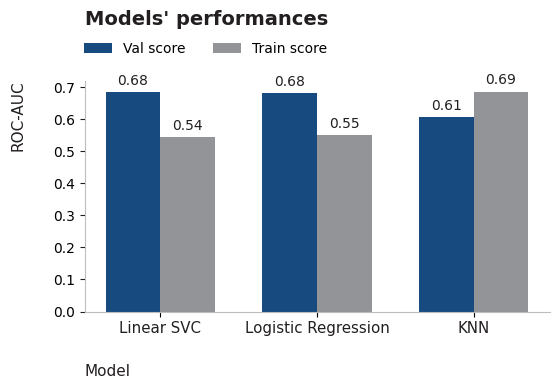

In [ ]:
# Stratified K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_feature_selected_sample_linear, 
                                  y_train=y_feature_sample, 
                                  n_folds=5)
plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(6, 3), title_size=14, legend_x=0.26, legend_y=1.22, title_pad=40)
eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 0.9889073130557149
Average validation score: 0.5527333454118356
Standard deviation: 0.0017605121159017811
Training time: 0.69867 seconds

Random Forest results: 
--------------------------------------------------
Training score: 0.9904607615497982
Average validation score: 0.6664550788238194
Standard deviation: 0.0048782106976483575
Training time: 13.12791 seconds

LightGBM results: 
--------------------------------------------------
Training score: 0.5916763132268553
Average validation score: 0.699370961201937
Standard deviation: 0.004148204577988764
Training time: 1.0492 seconds



,model,avg_val_score,train_score
0,LightGBM,0.699371,0.591676
1,Random Forest,0.666455,0.990461
2,Decision Tree,0.552733,0.988907


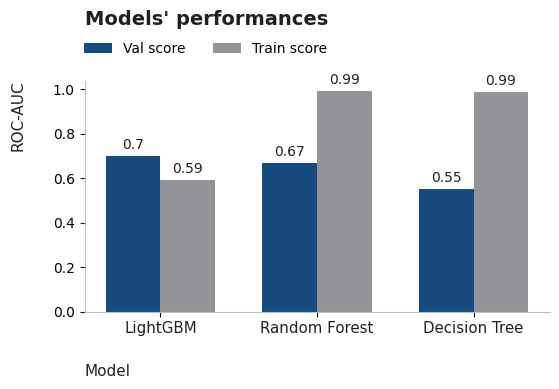

In [30]:
# K-fold cross validation for tree-based models.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_feature_selected_sample_linear, 
                                  y_train=y_feature_sample, 
                                  n_folds=5)
plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(6, 3), title_size=14, legend_x=0.26, legend_y=1.22, title_pad=40)
eval_df

- Dado que o melhor modelo foi o LightGBM e que estamos focando em poder preditivo, irei prosseguir com ele para a seleção de features e tunagem de hiperparâmetros. Apesar de o ajuste não ter sido tão bom (analisando o score de treino), o score de validação ainda é o maior. Além disso, o seu tempo de treinamento está ótimo. Por isso seu nome começa com "light"!

#### 6. Tunagem de hiperparâmetros
- Irei tunar os hiperparâmetros do LightGBM utilizando a otimização bayesiana através da biblioteca optuna.
- A otimização bayesiana realiza buscas inteligentes no espaço de hiperparâmetros do modelo, balanceando o trade-off exploration-exploitation.
- O grid search é ineficiente pois realiza uma busca exaustiva, testando todas as combinações de parâmetros possíveis e não considerando efeitos da interação entre parâmetros. Isso seria ruim no nosso caso, pois o conjunto de dados de treinamento é extenso e parâmetros como o número de árvores e a taxa de aprendizado estão relacionados a outros.
- A tunagem de hiperparâmetros representa um refinamento. O que melhora consideravelmente a performance do modelo é a etapa de feature engineering.
- Da mesma forma que na validação cruzada, uma vez que a tunagem de hiperparâmetros representa apenas um ajuste fino, não impactando de forma significativa a performance do modelo, e dados os meus recursos computacionais limitados, irei utilizar uma amostra de 100,000 linhas do conjunto de treinamento. Esse volume permitirá uma boa representatividade para ajustar os hiperparâmetros.
- A referência adotada para escolha dos hiperparâmetros pode ser encontrada no link a seguir. Normalmente, um maior número de árvores e iterações seria definido. Entretanto, dado o volume de dados, esses parâmetros serão reduzidos.

- https://www.linkedin.com/posts/pedro-almeida-ds_voc%C3%AA-fica-perdido-sobre-quais-combina%C3%A7%C3%B5es-activity-7168232226965385216-bvtw?utm_source=share&utm_medium=member_desktop

In [ ]:
# Finally preprocess train, validation and test sets
X_train_prepared = X_train.copy()
X_val_prepared = X_val.copy()
X_test_prepared = X_test.copy()

# Create region variable.
region_mapping = {
            'AC': 'Norte',
            'AL': 'Nordeste',
            'AP': 'Norte',
            'AM': 'Norte',
            'BA': 'Nordeste',
            'CE': 'Nordeste',
            'DF': 'Centro-Oeste',
            'ES': 'Sudeste',
            'GO': 'Centro-Oeste',
            'MA': 'Nordeste',
            'MT': 'Centro-Oeste',
            'MS': 'Centro-Oeste',
            'MG': 'Sudeste',
            'PA': 'Norte',
            'PB': 'Nordeste',
            'PR': 'Sul',
            'PE': 'Nordeste',
            'PI': 'Nordeste',
            'RJ': 'Sudeste',
            'RN': 'Nordeste',
            'RS': 'Sul',
            'RO': 'Norte',
            'RR': 'Norte',
            'SC': 'Sul',
            'SP': 'Sudeste',
            'SE': 'Nordeste',
            'TO': 'Norte'
        }
X_train_prepared['regiao'] = X_train_prepared['uf_prova'].replace(region_mapping)
X_val_prepared['regiao'] = X_val_prepared['uf_prova'].replace(region_mapping)
X_test_prepared['regiao'] = X_test_prepared['uf_prova'].replace(region_mapping)

# Combine similar target distributed low proportion income categories.
income_mapping = {
                            'Nenhuma Renda': 'Nenhuma Renda',
                            'Até R$ 1.320,00': 'Renda Baixa',
                            'R$ 1.320,01 - R$ 1.980,00': 'Renda Baixa',
                            'R$ 1.980,01 - R$ 2.640,00': 'Renda Baixa',
                            'R$ 2.640,01 - R$ 3.300,00': 'Renda Média Baixa',
                            'R$ 3.300,01 - R$ 3.960,00': 'Renda Média Baixa',
                            'R$ 3.960,01 - R$ 5.280,00': 'Renda Média Baixa',
                            'R$ 5.280,01 - R$ 6.600,00': 'Renda Média Alta',
                            'R$ 6.600,01 - R$ 7.920,00': 'Renda Média Alta',
                            'R$ 7.920,01 - R$ 9.240,00': 'Renda Média Alta',
                            'R$ 9.240,01 - R$ 10.560,00': 'Renda Média Alta',
                            'R$ 10.560,01 - R$ 11.880,00': 'Renda Alta',
                            'R$ 11.880,01 - R$ 13.200,00': 'Renda Alta',
                            'R$ 13.200,01 - R$ 15.840,00': 'Renda Alta',
                            'R$ 15.840,01 - R$ 19.800,00': 'Renda Alta',
                            'R$ 19.800,01 - R$ 26.400,00': 'Renda Alta',
                            'Acima de R$ 26.400,00': 'Renda Alta'
                        }
X_train_prepared['renda_familiar_mensal_cat'] = X_train_prepared['renda_familiar_mensal'].replace(income_mapping)
X_val_prepared['renda_familiar_mensal_cat'] = X_val_prepared['renda_familiar_mensal'].replace(income_mapping)
X_test_prepared['renda_familiar_mensal_cat'] = X_test_prepared['renda_familiar_mensal'].replace(income_mapping)

# Combine similar target distributed low proportion estado civil categories.
estado_civil_mapping = {
            'Solteiro(a)': 'Solteiro(a)',
            'Casado(a)/União Estável': 'Casado(a)/União Estável',
            'Não informado': 'Não informado',
            'Divorciado(a)/Separado(a)': 'Divorciado/Viúvo',
            'Viúvo(a)': 'Divorciado/Viúvo'
        }
X_train_prepared['estado_civil'] = X_train_prepared['estado_civil'].replace(estado_civil_mapping)
X_val_prepared['estado_civil'] = X_val_prepared['estado_civil'].replace(estado_civil_mapping)
X_test_prepared['estado_civil'] = X_test_prepared['estado_civil'].replace(estado_civil_mapping)

# Common category mappings
map_two_or_more = {
            'Zero': 'Zero',
            'Um': 'Um',
            'Dois': 'Dois ou mais',
            'Três': 'Dois ou mais',
            'Quatro ou mais': 'Dois ou mais'
        }
X_train_prepared['numero_motos_em_casa'] = X_train_prepared['numero_motos_em_casa'].map(map_two_or_more)
X_val_prepared['numero_motos_em_casa'] = X_val_prepared['numero_motos_em_casa'].map(map_two_or_more)
X_test_prepared['numero_motos_em_casa'] = X_test_prepared['numero_motos_em_casa'].map(map_two_or_more)

# Combine ano_concluiu categories.
X_train_prepared['ano_concluiu'] = X_train_prepared['ano_concluiu'].apply(lambda x: 11 if x > 10 else x )
X_val_prepared['ano_concluiu'] = X_val_prepared['ano_concluiu'].apply(lambda x: 11 if x > 10 else x )
X_test_prepared['ano_concluiu'] = X_test_prepared['ano_concluiu'].apply(lambda x: 11 if x > 10 else x )

# Ordinal and one hot encode some variables for post feature engineering
escolaridade_orders = ['Nunca estudou', 'Não sei', 'Ensino fundamental incompleto', 'Ensino fundamental completo', 'Ensino médio completo', 'Ensino superior completo', 'Pós-graduação']
four_or_more_orders = ['Zero', 'Um', 'Dois', 'Três', 'Quatro ou mais']
two_or_more_orders = ['Zero', 'Um', 'Dois ou mais']
ocupacao_orders = ['Não Informado', 'Agropecuária', 'Serviços Gerais', 'Produção e Operações', 'Técnicos e Pequenos Negócios', 'Profissionais e Liderança']
binary_orders = ['Não', 'Sim']
ordinal_encoding_orders = {
                            'status_conclusao_ensino_medio': ['Não concluído', 'Cursando', 'Último ano', 'Concluído'],
                            'escolaridade_pai': escolaridade_orders,
                            'escolaridade_mae': escolaridade_orders,
                            'renda_familiar_mensal_cat': ['Nenhuma Renda', 'Renda Baixa', 'Renda Média Baixa', 'Renda Média Alta', 'Renda Alta'],
                            'numero_tvs_em_casa': four_or_more_orders,
                            'numero_celulares_em_casa': four_or_more_orders,
                            'numero_computadores_em_casa': four_or_more_orders,
                            'numero_quartos_em_casa': four_or_more_orders,
                            'numero_motos_em_casa': two_or_more_orders,
                            'ocupacao_pai': ocupacao_orders,
                            'ocupacao_mae': ocupacao_orders,
                            'sexo': ['M', 'F'],
                            'lingua': ['Inglês', 'Espanhol'],
                            'possui_tv_assinatura_em_casa': binary_orders,
                            'possui_acesso_a_internet_em_casa': binary_orders,
                        }
ordinal_encoder = OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)
X_train_prepared = ordinal_encoder.fit_transform(X_train_prepared)
X_val_prepared = ordinal_encoder.transform(X_val_prepared)
X_test_prepared = ordinal_encoder.transform(X_test_prepared)

X_train_prepared['numero_pessoas_em_casa'] = X_train_prepared['numero_pessoas_em_casa'].astype('int32')
X_val_prepared['numero_pessoas_em_casa'] = X_val_prepared['numero_pessoas_em_casa'].astype('int32')
X_test_prepared['numero_pessoas_em_casa'] = X_test_prepared['numero_pessoas_em_casa'].astype('int32')
X_train_prepared['score_tecnologia_casa'] = (
    X_train_prepared['numero_computadores_em_casa'] + X_train_prepared['possui_acesso_a_internet_em_casa'] +
    X_train_prepared['numero_celulares_em_casa']
)
X_val_prepared['score_tecnologia_casa'] = (
    X_val_prepared['numero_computadores_em_casa'] + X_val_prepared['possui_acesso_a_internet_em_casa'] +
    X_val_prepared['numero_celulares_em_casa']
)
X_test_prepared['score_tecnologia_casa'] = (
    X_test_prepared['numero_computadores_em_casa'] + X_test_prepared['possui_acesso_a_internet_em_casa'] +
    X_test_prepared['numero_celulares_em_casa']
)
X_train_prepared['tecnologia_por_pessoa'] = (X_train_prepared['score_tecnologia_casa'] / X_train_prepared['numero_pessoas_em_casa']).astype('float32')
X_val_prepared['tecnologia_por_pessoa'] = (X_val_prepared['score_tecnologia_casa'] / X_val_prepared['numero_pessoas_em_casa']).astype('float32')
X_test_prepared['tecnologia_por_pessoa'] = (X_test_prepared['score_tecnologia_casa'] / X_test_prepared['numero_pessoas_em_casa']).astype('float32')
X_train_prepared['pessoas_por_quarto'] = (X_train_prepared['numero_pessoas_em_casa'] / X_train_prepared['numero_quartos_em_casa']).astype('float32')
X_val_prepared['pessoas_por_quarto'] = (X_val_prepared['numero_pessoas_em_casa'] / X_val_prepared['numero_quartos_em_casa']).astype('float32')
X_test_prepared['pessoas_por_quarto'] = (X_test_prepared['numero_pessoas_em_casa'] / X_test_prepared['numero_quartos_em_casa']).astype('float32')

# Leave only the features we want to use for feature selection.
to_drop_features = ['faixa_etaria', 'treineiro', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_redacao', 'numero_pessoas_em_casa', 
                    'renda_familiar_mensal', 'dias_empregado_domestico_em_casa', 'numero_banheiros_em_casa', 'numero_carros_em_casa', 'numero_geladeiras_em_casa', 'numero_freezers_em_casa', 
                    'numero_lavadoras_em_casa', 'numero_secadoras_em_casa', 'numero_microondas_em_casa', 'numero_lavadoras_de_loucas_em_casa', 'possui_aspirador_de_po_em_casa', 'possui_dvd_em_casa', 
                    'possui_telefone_fixo_em_casa', 'numero_quartos_em_casa', 'possui_acesso_a_internet_em_casa', 'score_tecnologia_casa']
column_dropper = ColumnDropper(to_drop=to_drop_features)
X_train_prepared = column_dropper.fit_transform(X_train_prepared)
X_val_prepared = column_dropper.transform(X_val_prepared)
X_test_prepared = column_dropper.transform(X_test_prepared)

# Apply target encoding to categorical variables with more than two categories.
target_encoding_features = ['escola', 'estado_civil', 'regiao']
target_encoder = TargetFeatureEncoder(to_encode=target_encoding_features)
X_train_prepared = target_encoder.fit_transform(X_train_prepared, y_train)
X_val_prepared = target_encoder.transform(X_val_prepared)
X_test_prepared = target_encoder.transform(X_test_prepared)

In [20]:
# Apply stratified sampling to obtain a representative subset of the dataset
X_train_prepared_sample, _, y_train_sample, _ = train_test_split(X_train_prepared, y_train, train_size=100_000, stratify=y_train, random_state=42)

In [ ]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'verbosity': -1,
        'bagging_freq': 1,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }
    
    # Stratified KFold in order to maintain the target proportion on each validation fold - dealing with imbalanced target.
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Evaluate the model using k-fold cross validation, obtaining a robust measurement of its performance on unseen data.
    val_scores = cross_val_score(LGBMClassifier(**params), X_train_prepared_sample, y_train_sample, scoring='roc_auc', cv=stratified_kfold)
    avg_val_score = val_scores.mean()

    return avg_val_score

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-07-20 12:25:56,278] A new study created in memory with name: no-name-45f1f88d-b6a6-4296-af3c-f4bcc844d827


[I 2025-07-20 12:26:24,512] Trial 0 finished with value: 0.6943806369060207 and parameters: {'learning_rate': 0.06420291196917649, 'num_leaves': 63, 'subsample': 0.5301653993586299, 'colsample_bytree': 0.12734643973470455, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.6943806369060207.
[I 2025-07-20 12:30:33,434] Trial 1 finished with value: 0.6981670140860793 and parameters: {'learning_rate': 0.003216718172146522, 'num_leaves': 569, 'subsample': 0.38008572023607695, 'colsample_bytree': 0.492687482002865, 'min_data_in_leaf': 38}. Best is trial 1 with value: 0.6981670140860793.
[I 2025-07-20 12:32:43,046] Trial 2 finished with value: 0.6835070021168685 and parameters: {'learning_rate': 0.01960281570021048, 'num_leaves': 237, 'subsample': 0.9813238555788846, 'colsample_bytree': 0.6361953890719138, 'min_data_in_leaf': 62}. Best is trial 1 with value: 0.6981670140860793.
[I 2025-07-20 12:36:02,580] Trial 3 finished with value: 0.6632529623303527 and parameters: {'learning_rate': 0

Best Hyperparameters: {'learning_rate': 0.007861530473811513, 'num_leaves': 14, 'subsample': 0.7380236151782277, 'colsample_bytree': 0.7203451205525283, 'min_data_in_leaf': 33}


In [13]:
best_params = {'objective': 'binary',
               'metric': 'roc_auc',
               'verbosity': -1,
               'bagging_freq': 1,
               'n_estimators': 1000,
               'learning_rate': 0.007861530473811513, 
               'num_leaves': 14, 
               'subsample': 0.7380236151782277, 
               'colsample_bytree': 0.7203451205525283, 
               'min_data_in_leaf': 33}

#### 7. Calibração de probabilidades
- Uma vez que queremos probabilidades realistas confiáveis de o candidato se abster em pelo menos um dos dois dias de prova do enem, realizarei a calibração das probabilidades do modelo LightGBM final.
- Isso é necessário pois modelos baseados em árvore, como o LightGBM, ao contrário de uma Regressão Logística, por exemplo, não fornecem probabilidades realistas, mas sim infladas.
- Dessa forma, é necessário realizar a calibração, para que por exemplo, se o modelo prevê que 10 indivíduos têm 40% de probabilidade de abstenção, 4 deles sejam de fato positivos para ausência em pelo menos um dos dias de prova.
- Para atingir essa calibração, irei aplicar uma Isotonic Regression sobre o LightGBM final utilizando o conjunto de validação, avaliando o Brier Score e sua redução e as curvas de calibração.
- A Regressão Isotônica é um método de calibração que ajusta as probabilidades previstas por um modelo para que sejam monotonicamente crescentes e mais alinhadas com as frequências empíricas observadas, sem assumir forma paramétrica. Ela aprende, a partir de um conjunto de validação, uma função de passo crescente que minimiza o erro quadrático entre as previsões ajustadas e os rótulos reais, melhorando a confiabilidade probabilística do modelo.
- O Brier Score mede a precisão das probabilidades previstas, sendo a média do erro quadrático entre previsão e classe real — quanto menor, melhor a calibração.

Brier score: 0.1930410111912043


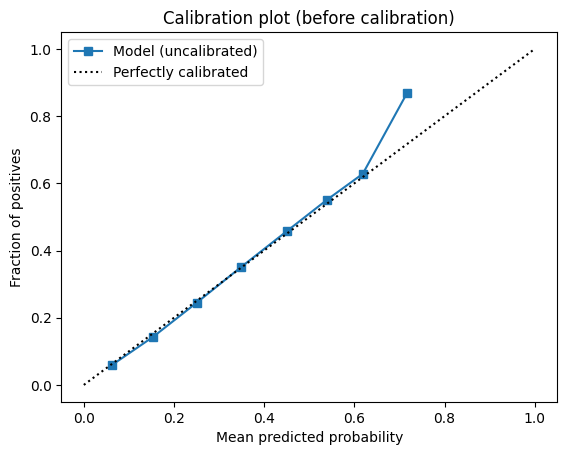

Brier score: 0.1928784405983701


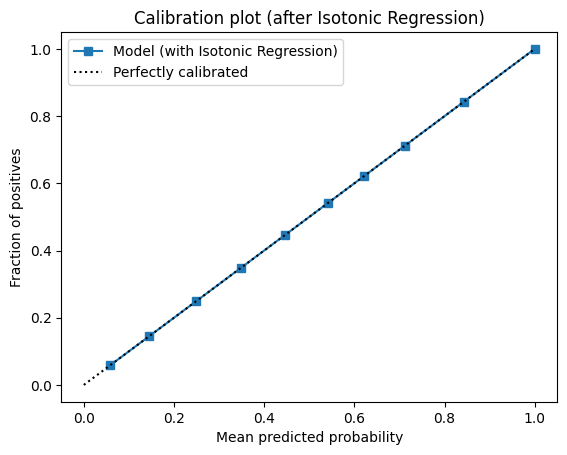

In [14]:
# Fit and calibrate the model with the best hyperparameters.
lgb = LGBMClassifier(**best_params)
lgb.fit(X_train_prepared, y_train)
calibrated_lgb = calibrate_model(lgb, X_val_prepared, y_val)

#### Avaliação do modelo final
- Avaliarei a performance do modelo final tunado e calibrado no conjunto de testes, dados nunca vistos antes pelo modelo, simulando completamente o ambiente de produção.
- Para avaliá-lo, serão analisadas algumas métricas, como o ROC-AUC, PR-AUC, KS, Gini, recall, precision e brier score.
- Para o nosso problema, em que temos uma classificação binária desbalanceada, as principais métricas são o ROC-AUC e o KS. Considerando que estamos focando em probabilidades, o brier score também é interessante.
- Após avaliar o modelo, eu irei interpretar os seus resultados.

              precision    recall  f1-score   support

           0       0.73      0.89      0.80    200870
           1       0.54      0.28      0.37     93666

    accuracy                           0.70    294536
   macro avg       0.63      0.59      0.58    294536
weighted avg       0.67      0.70      0.66    294536

Brier Score: 0.19
Gini: 0.41
KS: 0.3


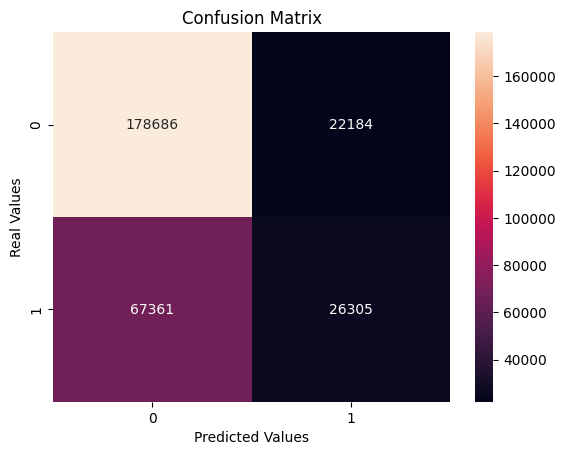

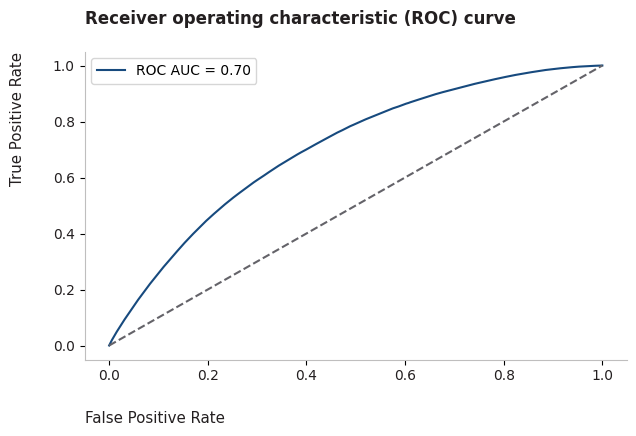

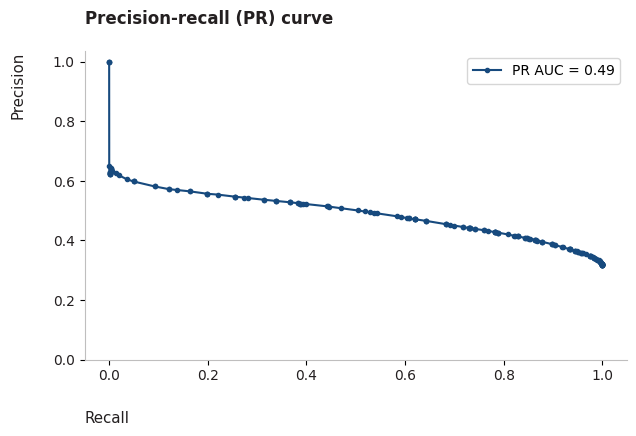

In [15]:
# predict the probabilities and labels for the test set.
y_pred = calibrated_lgb.predict(X_test_prepared)
absent_probas = calibrated_lgb.predict_proba(X_test_prepared)[:, 1]

# Evaluate the classifier based on a bunch of metrics.
model_metrics = evaluate_classifier(y_test, y_pred, absent_probas)

In [16]:
model_metrics

,Metric,Value
0,Accuracy,0.695979
1,Precision,0.542494
2,Recall,0.280838
3,F1-Score,0.370089
4,ROC-AUC,0.704071
5,KS,0.300904
6,Gini,0.408142
7,PR-AUC,0.491343
8,Brier,0.193333


- Com foco na qualidade probabilística das previsões, e não em classificações binárias, os resultados do modelo mostram um desempenho bastante satisfatório.
- O ROC-AUC de 0.704 indica uma boa capacidade discriminativa: O modelo consegue ordenar corretamente os exemplos positivos e negativos em grande parte das vezes. Na prática, se tomarmos ao acaso um candidato que esteve ausente e um que não esteve, 70% das vezes o modelo atribui maior probabilidade de abstenção ao candidato que de fato esteve ausente. 
- Já o KS de 0.301 reforça essa habilidade de separação entre distribuições de positivos e negativos, com valor considerado satisfatório para aplicações práticas. 
- O Brier Score de 0.193 mostra que há espaço para melhorar a calibração das probabilidades, já que valores mais próximos de zero indicam maior confiabilidade nas previsões probabilísticas. Apesar de não ser um valor alarmante, ele sinaliza que métodos de calibração — como a Regressão Isotônica aplicada — podem trazer ganhos em termos de realismo das probabilidades previstas.

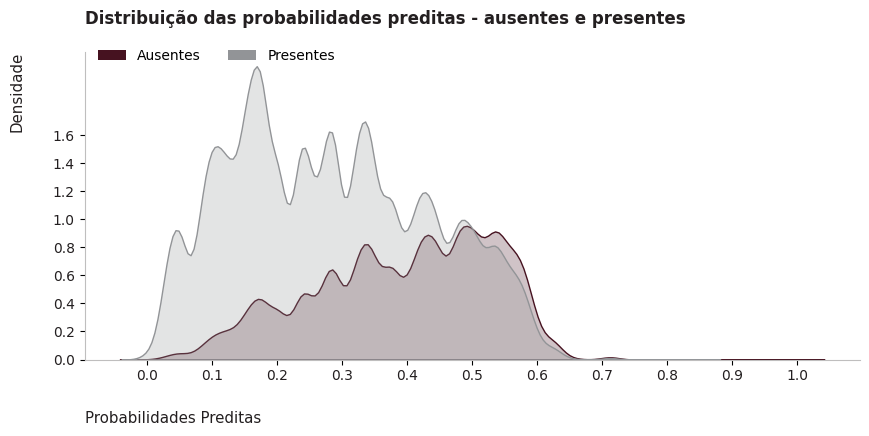

In [17]:
plot_probability_distributions(y_test, absent_probas)

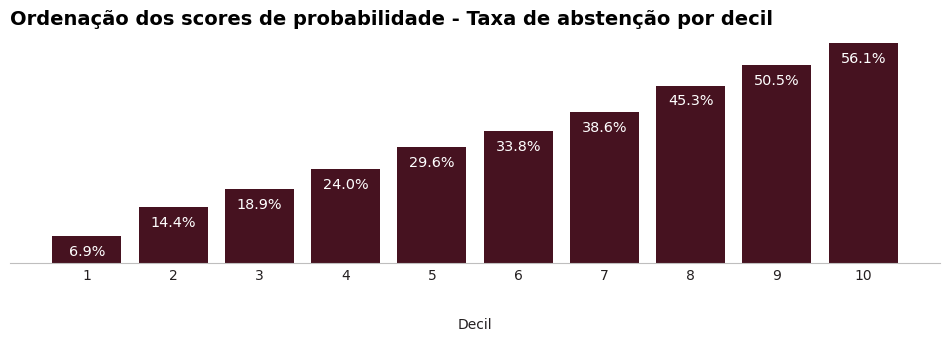

In [18]:
probability_scores_ordering(y_test, absent_probas)

- Nossos scores claramente seguem uma ordenação, o que é bom! É possível perceber que o percentual de candidatos ausentes é muito maior para faixas de probabilidade mais altas. Isso sugere que, apesar de não ser um modelo excepcional, é sim muito útil para prever a probabilidade de abstenção de um estudante no enem e realizar uma ordenação.

- Finalmente, vamos comparar o ROC AUC do modelo nas amostras de treino, teste e validação, a fim de se certificar que o modelo não está com overfit. 
- Além disso, é importante aplicar a validação cruzada k-fold mais uma vez, a fim de verificar a performance do modelo em diferentes conjuntos de dados nunca antes vistos. Isso mitiga efeitos da variabilidade dos dados e nos fornece uma visão concreta da capacidade de generalização do estimador.

In [24]:
# Predict on train, test and validation sets.
y_pred_train = calibrated_lgb.predict_proba(X_train_prepared)[:, 1]
y_pred_val = calibrated_lgb.predict_proba(X_val_prepared)[:, 1]
y_pred_test = absent_probas

# K-fold cross validation
cv_scores = cross_val_score(LGBMClassifier(**best_params),
                            X_train_prepared,
                            y_train,
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
roc_auc_cv = np.mean(cv_scores)

# Obtain ROC AUC on each of these sets.
roc_auc_train = round(roc_auc_score(y_train, y_pred_train), 2)
roc_auc_test = round(roc_auc_score(y_test, y_pred_test), 2)
roc_auc_val = round(roc_auc_score(y_val, y_pred_val), 2)

# Output a dataframe for better visualization.
roc_auc_sets = pd.DataFrame({'ROC AUC': [roc_auc_train, roc_auc_test, roc_auc_val, roc_auc_cv]}, index=['Train', 'Test', 'Val', 'Cross Val'])
roc_auc_sets

,ROC AUC
Train,0.70000
Test,0.70000
Val,0.71000
Cross Val,0.70409


- Os scores nos conjuntos de treino, teste e validação e na validação cruzada k-fold são aproximadamente iguais. Portanto, o modelo não está com overfitting e generaliza de forma satisfatória para instâncias nunca antes vistas.

#### 9. Interpretação dos resultados
- Para interpretar os resultados do LightGBM, vou analisar os valores SHAP.
- SHAP é uma biblioteca que permite a interpretação dos resultados de algoritmos de machine learning.
- Com ela, podemos entender o impacto de cada característica em uma previsão individual do modelo.
- Basicamente, o valor SHAP de uma característica (o quanto ela impacta em uma previsão individual) é a soma ponderada das contribuições marginais considerando todas as possíveis combinações de características.
- Uma combinação de características é um grupo delas, e seu valor é a previsão individual do modelo utilizando apenas essas características.
- A contribuição marginal de uma característica é a diferença entre o valor previsto para uma combinação de características com ela e sem ela.
- Somamos as contribuições marginais para todas as possíveis combinações com e sem uma característica.
- Os pesos são baseados na probabilidade de a característica que estamos calculando o valor SHAP estar nessa combinação.
- Também podemos agregar as contribuições individuais, obtendo uma noção das feature importances. Vários plots serão explorados abaixo.

$$
\phi_i(v) = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F| - |S| - 1)!}{|F|!} \left[ f(S \cup \{i\}) - f(S) \right]
$$

Onde:
- $ \phi_i(v) $ representa o SHAP value da feature $ i $ para a predição $ v $.
- $ F $ representa o conjunto de todas as features.
- $ S $ representa um subset de features excluindo a feature $ i $.
- $ f $ é a função de predição do modelo.

In [26]:
# Initialize the SHAP explainer with the final model.
explainer = shap.Explainer(lgb)

# Compute shap values.
shap_values = explainer(X_test_prepared)

In [27]:
# Assess the shape.
np.shape(shap_values.values)

(294536, 19)

In [28]:
# Assess some true labels.
y_test.head(10)

2456762    1
594211     0
149422     0
3384843    0
2798432    0
426362     0
3601674    0
2446213    0
222566     1
376509     1
Name: abstencao, dtype: int8

In [29]:
# Assess predicted probabilities of being absent.
absent_probas[0:10]

array([0.35545107, 0.20526688, 0.37964976, 0.53297172, 0.10617439,
       0.42154933, 0.57199461, 0.08348   , 0.40500736, 0.40493261])

- Temos 19 variáveis. Para cada uma temos um valor shap correspondente a cada observação.
- Para classificação binária, interpretamos os resultados em termos de log-odds. Nos gráficos a seguir, E(f(X)) representa a previsão média de log-odds. O log-odds é basicamente o logaritmo da odds, razão entre a probabilidade de o evento acontecer e a probabilidade de o evento não acontecer. O logaritmo é utilizado para converter a odds a uma escala linear. Os Valores de shap positivos aumentam o log-odds e, consequentemente, a probabilidade de abstenção, e vice-versa.
- Para obter a probabilidade de abstenção a partir do log-odds, basta passar a função logística, definida como $$ \text{sigmoid}(x) = \frac{1}{1 + e^{-\ln\left(\frac{p}{1-p}\right)}} $$

- Através do gráfico waterfall, iremos visualizar a contribuição de cada feature na predição para uma instância positiva (ausente) e negativa (presente).

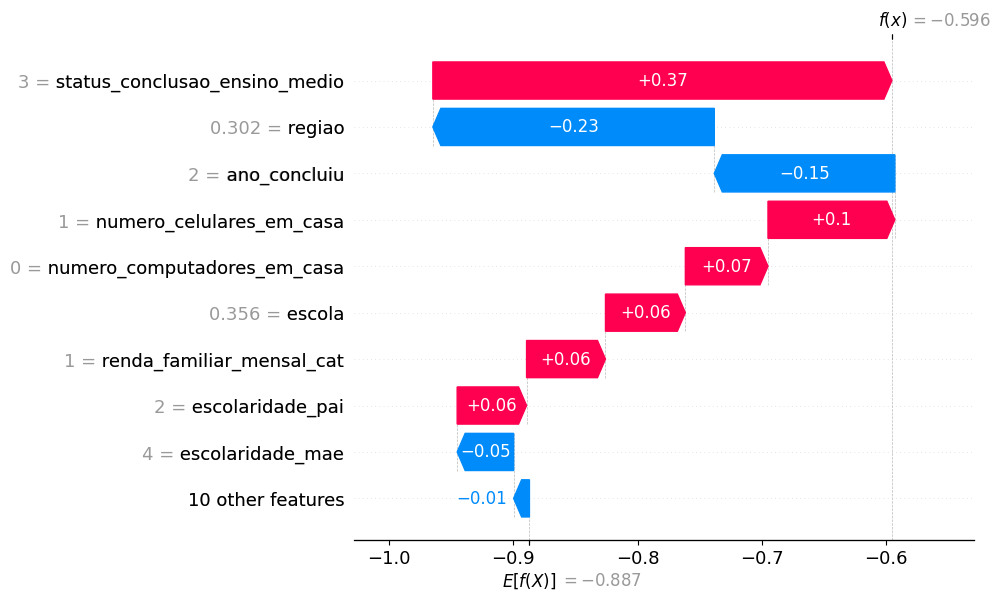

In [30]:
shap.plots.waterfall(shap_values[0])

In [34]:
1/(1+np.exp(0.596))

np.float64(0.35525936300713196)

- Este candidato estava ausente (1). A probabilidade de abstenção estimada para ele através da função logística mencionada acima é de aproximadamente 0.35.
- É possível perceber que o status de conclusão do ensino médio, que é igual a 3 (Concluído) neste caso, aumentou o log-odds em 0.37. Isso faz total sentido, uma vez que foi visto na eda que pessoas que já concluíram o ensino médio tinham taxas de abstenção maiores (41.5%) que outras faixas como os que estão no último ano (24.8%) ou ainda cursando (17.3%). O mesmo vale para a escolaridade do pai, que, estando em um nível baixo (2, ensino fundamental incompleto), aumenta o log-odds em 0.06 e, consequentemente, a probabilidade de abstenção. O mesmo para o baixo número de celulares e computadores em casa (um e nenhum) e a categoria de renda - Baixa Renda.

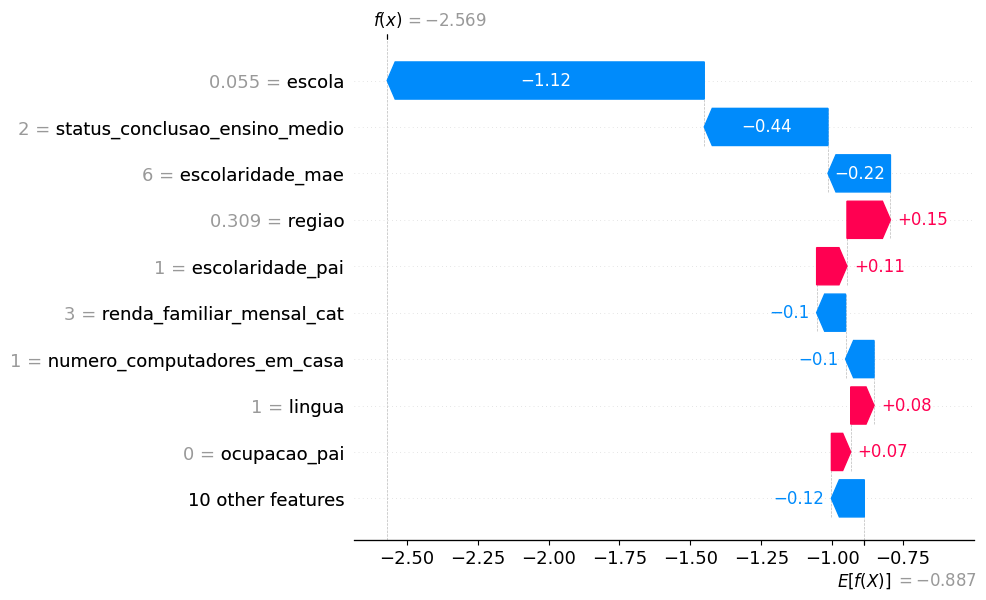

In [39]:
shap.plots.waterfall(shap_values[7])

- Este candidato estava presente (0). A probabilidade de abstenção estimada para ele através da função logística mencionada acima é de aproximadamente 0.07.
- O fato de ele ter estudado em escola privada diminui o log-odds em 1.12 para esse candidato. Isso faz total sentido, uma vez que foi visto na eda que este grupo possui uma taxa de abstenção 5 vezes menor quando comparado a alunos de escola pública, e consequentemente, probabilidade de abstenção. O mesmo vale para a escolaridade da mãe, que é a maior possível, 6/pós-graduação, reduzindo o log-odds em 0.22. O mesmo para o status de conclusão do ensino médio, que é de último ano, representando uma menor abstenção como na eda, e reduzindo o log-odds em 0.44.

- Agora, através do gráfico bar, iremos observer quais features são mais importantes. Neste gráfico, temos o shap absoluto médio para cada feature, indicando quais features contribuem mais (de forma positiva ou negativa) nas predições do modelo.

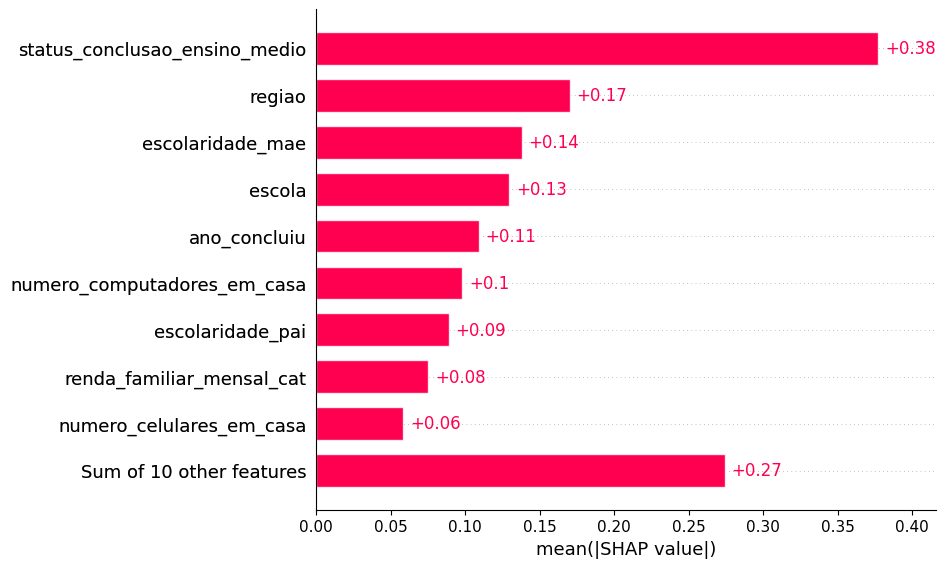

In [44]:
shap.plots.bar(shap_values)

- Como esperado, variáveis como o status de conclusão do ensino médio, a região, a escolaridade da mãe, o tipo de escola, indicadores tecnológicos e a renda impactam de forma mais significativa os resultados do modelo. Com destaque para o status de conclusão do ensino médio, que é a mais importante de todas, com um shap absoluto médio de 0.38. 

- Agora, através do gráfico beeswarm, podemos observar o relacionamento entre as features e a predição do modelo.

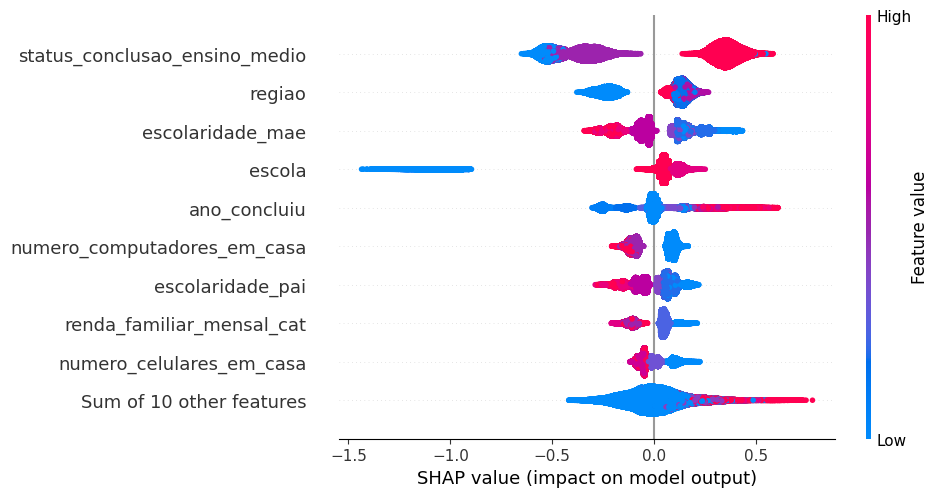

In [45]:
shap.plots.beeswarm(shap_values)

- Claramente, candidatos que já concluiram o ensino médio, em estágio mais avançado nesse quesito, impactam de forma positiva (em maior magnitude) as predições do modelo. Isso significa um aumento na log-odds e, consequentemente, na probabilidade de abstenção. Isso é reforçado pela variável ano_concluiu.
- O contrário é verdade para o número de celulares e computadores em casa. A separação é clara, quanto menor for o número, maior a probabilidade de abstenção e vice-versa. O mesmo vale para a escolaridade da mãe e do pai.
- Para o tipo de escola, temos uma clara separação. Valores menores, que correspondem a escola particular, impactam de forma negativa (em maior magnitude) as predições do modelo. Isso significa uma diminuição na log-odds e, consequentemente, na probabilidade de abstenção.
- Para renda, menores valores acarretam um aumento na log-odds e na probabilidade de abstenção.
- Todas as interpretações condizem com a lógica e os insights da análise exploratória, provando que o modelo toma decisões de acordo com a realidade e não de forma aleatória.

#### Conclusão
- Neste notebook, foi desenvolvido um modelo preditivo (LightGBM) para predição da probabilidade de abstenção do candidato no enem.
- Considerando que trata-se de uma classificação binária desbalanceada (temos aproximadamente 32% de ausentes contra 68% de presentes), algumas estratégias foram adotadas:
    - Divisão ESTRATIFICADA em treino, teste e validação, para manter a proporção das classes positiva e negativa do target em todas as amostras, permitindo uma avaliação confiável.
    - Validação cruzada k-fold ESTRATIFICADA pelo mesmo motivo.
    - Feature engineering na criação de features que ajudem o modelo a discriminar entre o evento (abstenção, 1) e o não evento.
    - Escolha de métricas orientadas a uma avaliação de performance condizente com o desbalanceamento, como PR-AUC, ROC-AUC, KS, e brier score.
- Foram consideradas diversas variáveis na construção do modelo. Os insights obtidos na etapa de análise exploratória de dados serviram de guia para a tarefa pré-processamento de dados, necessária para a aplicação de algoritmos de machine learning.
- Após a feature engineering/pré-processamento de dados e feature selection, avaliamos através da validação cruzada k-fold estratificada modelos potenciais, a fim de selecionar um deles para a tunagem de hiperparâmetros, calibração de probabilidades e avaliação final no conjunto de testes, simulando o ambiente de produção. O modelo selecionado foi o LightGBM por ter obtido o maior ROC-AUC de validação e o melhor ajuste no conjunto de treinamento.
- Realizei a feature selection através de um pipeline simples e robusto, fazendo cortes por nulos, correlação, variância, e feature importance, restando 19 variáveis, simplificando o modelo e diminuindo o custo, dado que temos milhões de linhas.
- O resultado obtido foi satisfatório, porém há espaço para melhorias:
    - Obtivemos um ROC AUC de 0.70, indicando que o modelo possui um poder discriminante satisfatório entre as classes positiva e negativa. Isso nos indica que, se tomarmos ao acaso um candidato ausente e um presente, em 70% das vezes o modelo estimará uma probabilidade de abstenção mais alta para aquele que de fato se absteve.
    - O modelo apresenta ordenação nos escores, com faixas de probabilidade mais altas contendo mais ausentes.
    - Os erros nas amostras de treino, teste e validação são similares, indicando que o modelo não está com overfit e generaliza de forma satisfatória para instâncias nunca antes vistas.
- Os resultados foram interpretados através da biblioteca SHAP, fornecendo uma visão do impacto de cada variável nas predições individuais e a sua importância agregada através dos SHAP values. Por exemplo, através do gráfico beeswarm, vemos que:
    - laramente, candidatos que já concluiram o ensino médio, em estágio mais avançado nesse quesito, impactam de forma positiva (em maior magnitude) as predições do modelo. Isso significa um aumento na log-odds e, consequentemente, na probabilidade de abstenção. Isso é reforçado pela variável ano_concluiu.
    - Para o tipo de escola, temos uma clara separação. Valores menores, que correspondem a escola particular, impactam de forma negativa as predições do modelo. Isso significa uma diminuição na log-odds e, consequentemente, na probabilidade de abstenção.
    - Para renda e indicadores de tecnologia, o contrário é verdadeiro, menores valores acarretam um aumento na log-odds e na probabilidade de abstenção.
- Os próximos passos incluem o deploy do modelo.